# 라이브러리 및 GPU확인

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import torch

In [10]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [11]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jun 20 02:35:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [13]:
!pip install lightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightly-1.2.19-py3-none-any.whl (449 kB)
  Using cached pytorch_lightning-1.6.4-py3-none-any.whl (585 kB)
  Using cached hydra_core-1.2.0-py3-none-any.whl (151 kB)
  Using cached lightly_utils-0.0.2-py3-none-any.whl (6.4 kB)
  Using cached antlr4-python3-runtime-4.9.3.tar.gz (117 kB)
  Using cached omegaconf-2.2.2-py3-none-any.whl (79 kB)
     |████████████████████████████████| 596 kB 11.9 MB/s 
     |████████████████████████████████| 140 kB 59.9 MB/s 
     |████████████████████████████████| 419 kB 65.1 MB/s 
     |████████████████████████████████| 1.1 MB 63.9 MB/s 
     |████████████████████████████████| 144 kB 60.6 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 271 kB 63.3 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=ad82592731559613328804e

In [14]:
from torch import nn
import torchvision
import copy

from lightly.data import LightlyDataset
from lightly.data import SimCLRCollateFunction
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import BYOLProjectionHead
from lightly.models.utils import deactivate_requires_grad
from lightly.models.utils import update_momentum
import lightly

from lightly.data import SwaVCollateFunction
from lightly.loss import SwaVLoss
from lightly.models.modules import SwaVProjectionHead
from lightly.models.modules import SwaVPrototypes

from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image



# 모델

SwaV

In [15]:
class SwaV(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SwaVProjectionHead(512, 512, 128)
        self.prototypes = SwaVPrototypes(128, n_prototypes=512)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        x = self.projection_head(x)
        x = nn.functional.normalize(x, dim=1, p=2)
        p = self.prototypes(x)
        return p



In [16]:
path_to_data = '/content/drive/MyDrive/RHEED'
path_to_test = '/content/drive/MyDrive/Train'

In [17]:
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = SwaV(backbone)

In [18]:
device = "cuda"
model.to(device)

SwaV(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

# Hyperparameters

In [19]:
num_workers = 8
batch_size = 128
seed = 1
max_epochs = 50
input_size = 32
num_ftrs = 32


In [20]:
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])

In [21]:

collate_fn = SwaVCollateFunction(    
vf_prob=0.5,
rr_prob=0.5,
crop_sizes=[120, 96],
crop_counts=[2, 4],
cj_prob=0.5,
random_gray_scale=0.5
)


#collate_fn = lightly.data.collate.MultiCropCollateFunction(
#    crop_sizes = [48,48], crop_counts = [2,4],crop_min_scales = [10,10], crop_max_scales=[30,10], transforms = test_transforms)
    



dataset_train_simclr = lightly.data.LightlyDataset(
    input_dir=path_to_data,

)

dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_data,
    transform=test_transforms
)
dataset_test2 = lightly.data.LightlyDataset(
    input_dir=path_to_test,
    transform=test_transforms
)

dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)
dataloader_test2 = torch.utils.data.DataLoader(
    dataset_test2,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [22]:
torch.cuda.empty_cache()

In [23]:
criterion = SwaVLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
#model = torch.load('/content/drive/MyDrive/Models/model_SwAV100vr, rr, cj,crop.pt')
#model
#model.eval()

In [25]:
'''
print("Starting Training")
loss_history = []

for epoch in range(max_epochs):
    total_loss = 0
    for batch, _, _ in dataloader_train_simclr:
        model.prototypes.normalize()
        multi_crop_features = [model(x.to(device)) for x in batch]
        high_resolution = multi_crop_features[:2]
        low_resolution = multi_crop_features[2:]
        loss = criterion(high_resolution, low_resolution)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader_train_simclr)
    loss_history.append(avg_loss.float())

    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    '''


'\nprint("Starting Training")\nloss_history = []\n\nfor epoch in range(max_epochs):\n    total_loss = 0\n    for batch, _, _ in dataloader_train_simclr:\n        model.prototypes.normalize()\n        multi_crop_features = [model(x.to(device)) for x in batch]\n        high_resolution = multi_crop_features[:2]\n        low_resolution = multi_crop_features[2:]\n        loss = criterion(high_resolution, low_resolution)\n        total_loss += loss.detach()\n        loss.backward()\n        optimizer.step()\n        optimizer.zero_grad()\n    avg_loss = total_loss / len(dataloader_train_simclr)\n    loss_history.append(avg_loss.float())\n\n    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")\n    '

In [26]:
#loss_history

In [27]:
#plt.plot(loss_history)
#plt.show
#plt.savefig('loss_history'+str(max_epochs)+'vr, rr'+'.png')


In [28]:
#total_loss

In [228]:
model = torch.load('/content/drive/MyDrive/Models/model_SwAV50vr, rr, gaus, cj.pt')
#torch.save(model, '/content/drive/MyDrive/model_SwAV2_'+str(max_epochs)+'gauss' +'.pt')

In [256]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array
    """
    img = Image.open(filename)
    return np.asarray(img)


def plot_knn_examples(embeddings, filenames, n_neighbors=9, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors
    """
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_data, filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f'd={distances[idx][plot_x_offset]:.3f}')
            fig.set_size_inches(40,50)

            # let's disable the axis
            plt.axis('off')

In [257]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, label, fnames in dataloader:
            img = img.to('cuda')
            emb = model.backbone(img).cpu().flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

In [258]:
len(filenames)

2741

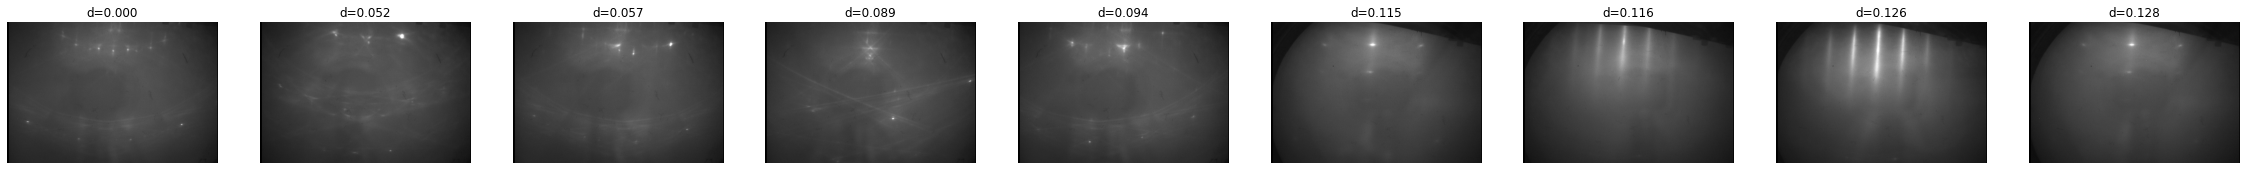

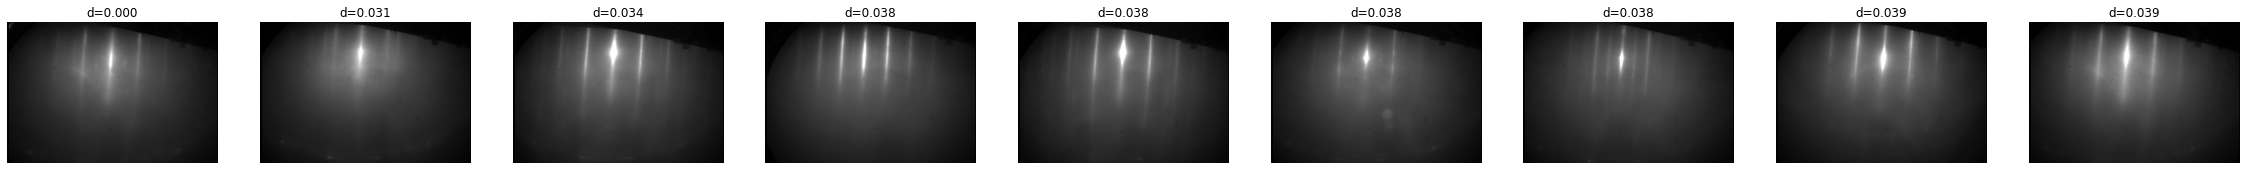

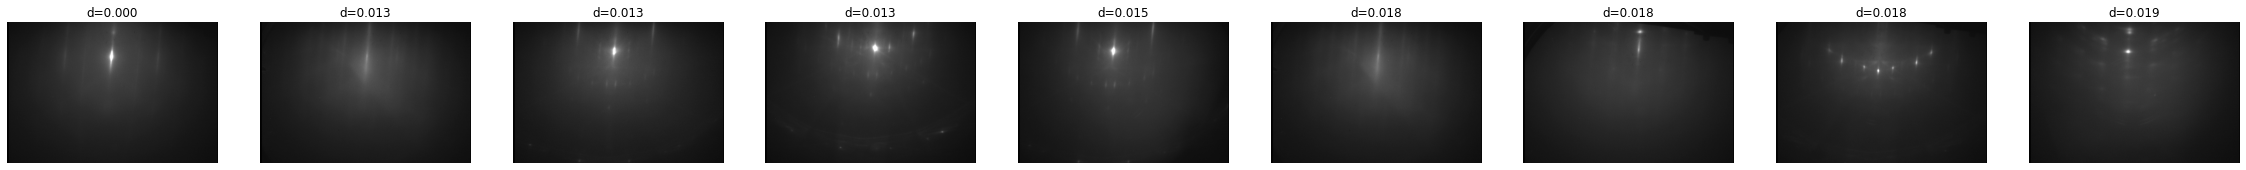

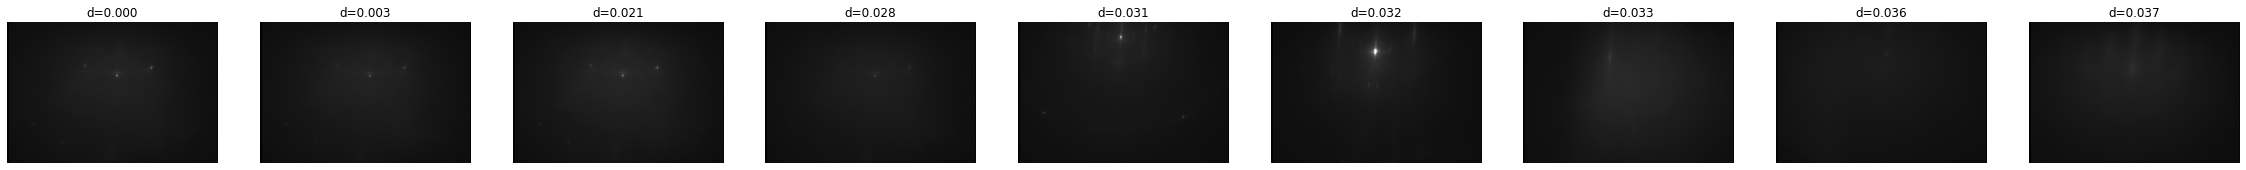

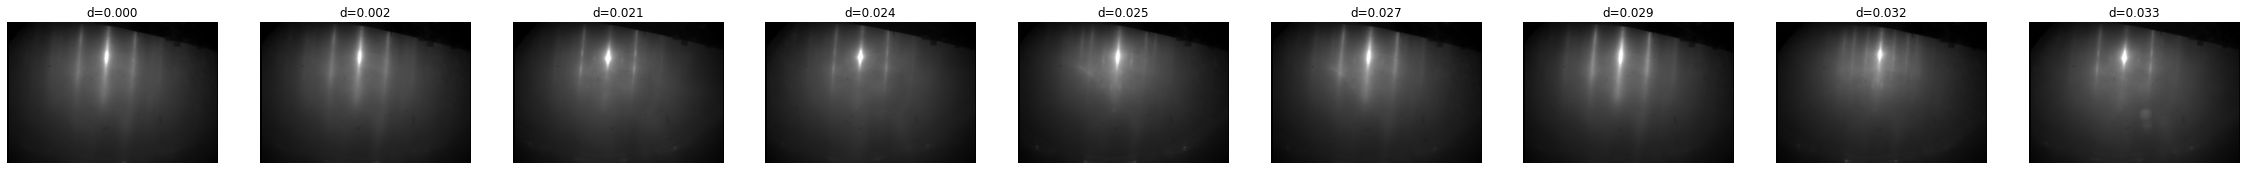

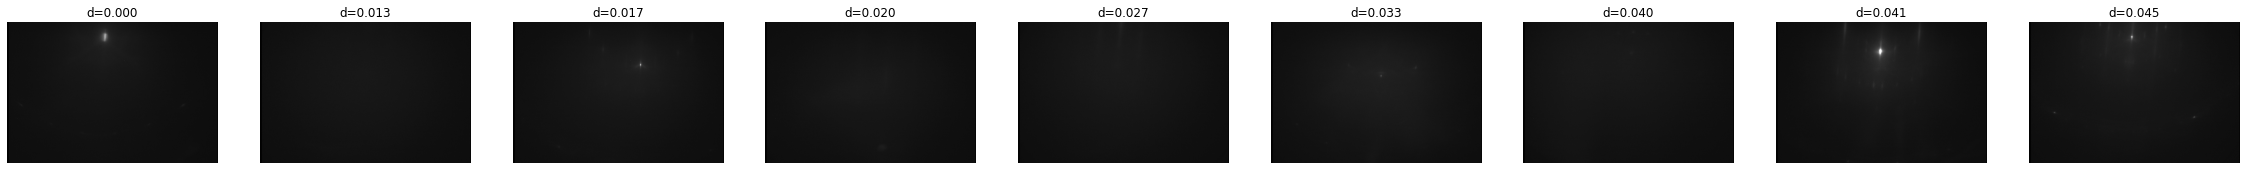

In [259]:
plot_knn_examples(embeddings, filenames)

In [260]:
# for plotting
import os
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp

# for resizing images to thumbnails
import torchvision.transforms.functional as functional

# for clustering and 2d representations
from sklearn import random_projection

In [261]:
import seaborn as sns
import pandas as pd

In [262]:
df_li = pd.read_csv("/content/drive/MyDrive/Samples/idx_sample.csv")
shown_list = df_li['0']
shown_lists = shown_list.tolist()
type(shown_lists)

list

In [263]:
# for the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)

# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

In [264]:
embeddings_2d.shape

(2741, 2)

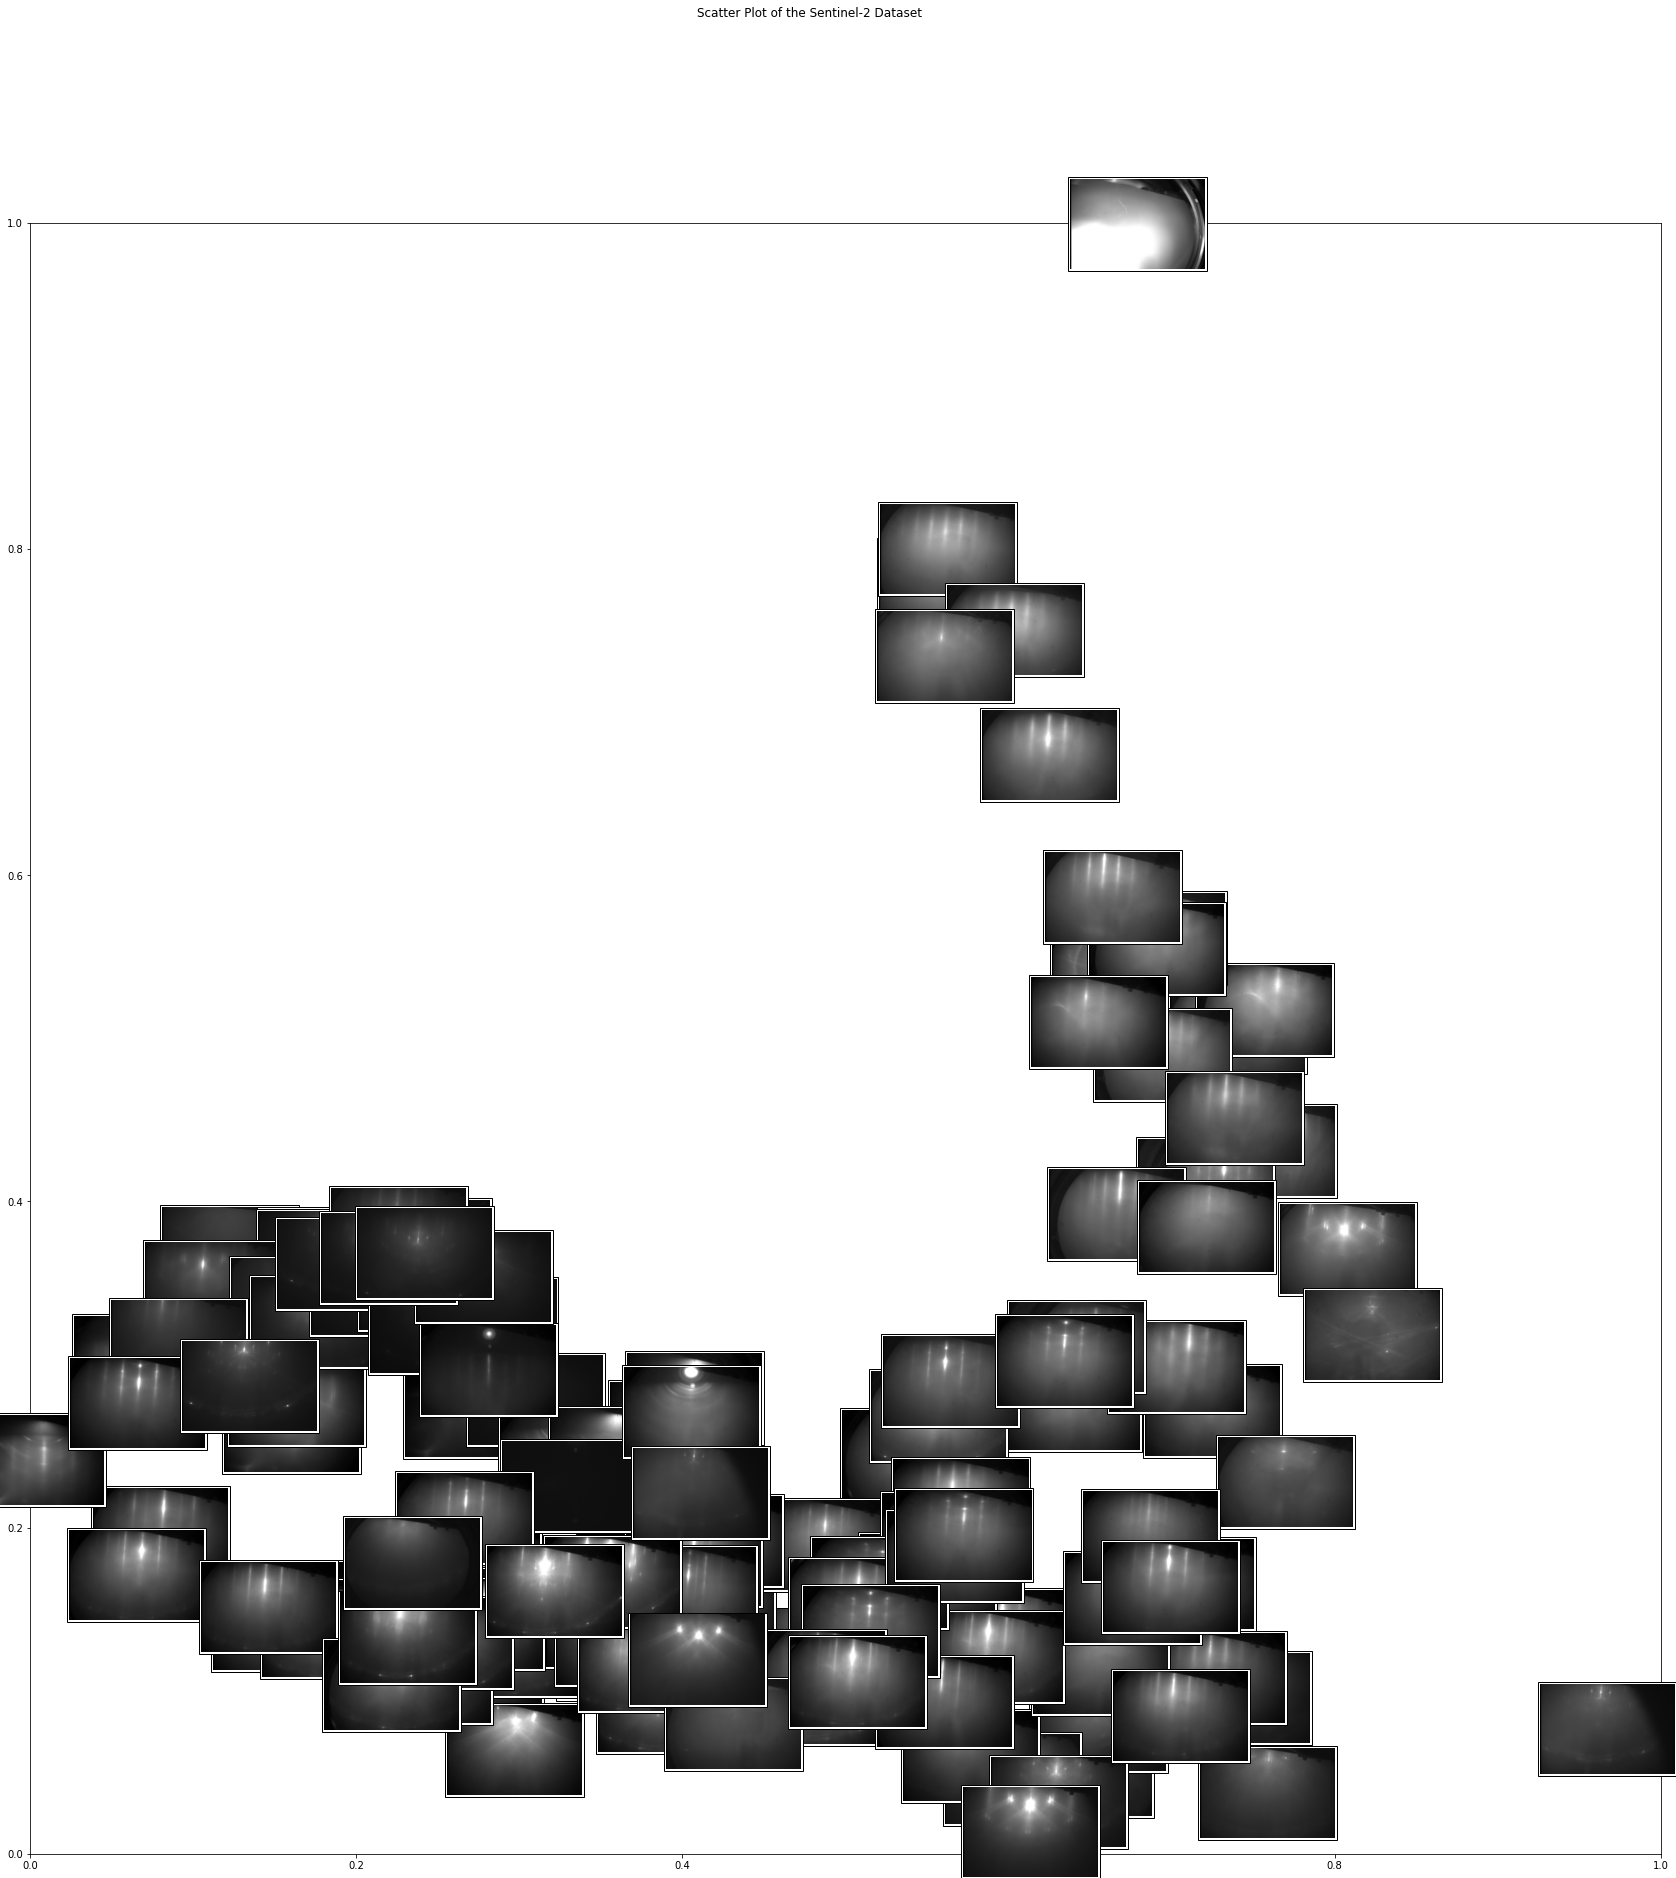

In [298]:
def get_scatter_plot_with_thumbnails():
    """Creates a scatter plot with image overlays.
    """
    # initialize empty figure and add subplot

    fig = plt.figure()
    fig.set_size_inches(40,30)

    fig.suptitle('Scatter Plot of the Sentinel-2 Dataset')
    ax = fig.add_subplot(1, 1, 1)

    '''
    # shuffle images and find out which images to show
    shown_images_idx = []
    shown_images = np.array([[1., 1.]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.seed(0)
    np.random.shuffle(iterator)
    for i in iterator:
        # only show image if it is sufficiently far away from the others
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        #if np.min(dist) < 2e-3:
        #    continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)
    print(shown_images_idx)
    arr1 = np.array(shown_images_idx)
#    np.save('/content/drive/MyDrive/idx.csv', arr1) 

    # plot image overlays
    filenames_solution=[]

'''
    shown_images_idx = shown_lists
    for idx in shown_images_idx:
        thumbnail_size = int(rcp['figure.figsize'][0] * 15.)
        path = os.path.join(path_to_data, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)
 #       filenames_solution.append(filenames[idx])
#    print(filenames_solution)
#    arr2 = np.array(filenames_solution)
#   np.save('/content/drive/MyDrive/fname.csv', arr2) 




    # set aspect ratio
    ratio = 1. / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable='box')
#    plt.savefig('/content/drive/MyDrive/Figures/' + 'savefig_default2'+str(max_epochs)+'vr,rr,crop'+'.png')

# get a scatter plot with thumbnail overlays
get_scatter_plot_with_thumbnails()

In [299]:
!ls

drive  sample_data


In [300]:
import seaborn as sns
import pandas as pd

In [301]:
df = pd.DataFrame(embeddings_2d, columns=['x','y'])


In [302]:
non=[]
non = [i for i in range(df.shape[0])]
droper=[]
droper = [x for x in non if x not in shown_lists]

In [303]:
len(droper)

2609

In [304]:
df = df.drop(droper)
df = df.reset_index()
df

,index,x,y
0,10,0.146137,0.151246
1,18,0.221431,0.103574
2,33,0.756752,0.517375
3,40,0.690631,0.554855
4,41,0.703216,0.298806
...,...,...,...
127,2624,0.273150,0.141076
128,2629,0.538973,0.244839
129,2653,0.080264,0.196450
130,2663,0.271331,0.174534


In [305]:
df2 = pd.read_csv('/content/drive/MyDrive/Samples/fname_sample - fname_sample.csv')
df2 = df2.drop(['설명: 1x1 1, 2x2 2, 3D 3, poly 4, 그래핀합성전 5, 그래핀6, 그래핀-1x1 7, 1x1 broad 8, flat substrate 9, dot 10, Broad 11'],axis=1)
df2

,Fname,Label,1순서
0,0103_15시43분_Video_1.jpg,1,25
1,0105_23시09분_Video700도어닐후.jpg,7,101
2,0109_19시10분_Video증착4분.jpg,3,64
3,0109_19시38분_Video증착완료.jpg,3,99
4,0109_20시15분_Video600어닐후.jpg,3,85
...,...,...,...
127,1213_18시11분_Video600도 어닐링후 250도 부ᄀ...,7,79
128,1213_19시10분_VideoSe처리2분.jpg,10,39
129,1214_19시02분_Video600도어닐후250도.jpg,8,5
130,1216_15시43분_Video.jpg,7,35


In [306]:
df2_s = df2

In [307]:
df2 = df2.sort_values(by=['1순서'], ascending=[True])
df2['Label'] = df2_s['Label']
df2 = df2.reset_index()
df2= df2.drop(['index'],axis=1)
df2

,Fname,Label,1순서
0,0416_14시32분_Video05.jpg,1,2
1,0707_20시28분_Video1-00.jpg,7,3
2,1101_13시34분_Video5.jpg,7,4
3,1214_19시02분_Video600도어닐후250도.jpg,8,5
4,1025_09시19분_Video 30m anneal.jpg,11,6
...,...,...,...
127,1014_21시55분_Video.jpg,9,129
128,1010_16시48분_Video.jpg,11,130
129,0126_17시52분_Video17분.jpg,7,131
130,0425_22시19분_Video07.jpg,1,132


In [308]:
df['Label'] = df2['Label']

In [292]:
df

,index,x,y,Label
0,10,0.146137,0.151246,1
1,18,0.221431,0.103574,7
2,33,0.756752,0.517375,7
3,40,0.690631,0.554855,8
4,41,0.703216,0.298806,11
...,...,...,...,...
127,2624,0.273150,0.141076,9
128,2629,0.538973,0.244839,11
129,2653,0.080264,0.196450,7
130,2663,0.271331,0.174534,1


In [309]:

D = [1,2,5,6,7,8]
E = [3,4,9,10]
F = [11]
for i in range(0,132):
  if df.iloc[i][3] in D:
    df['Label'][i]= 'A'
  if df.iloc[i][3] in E:
    df['Label'][i]='B'
  if df.iloc[i][3] in F:
    df['Label'][i]='C'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


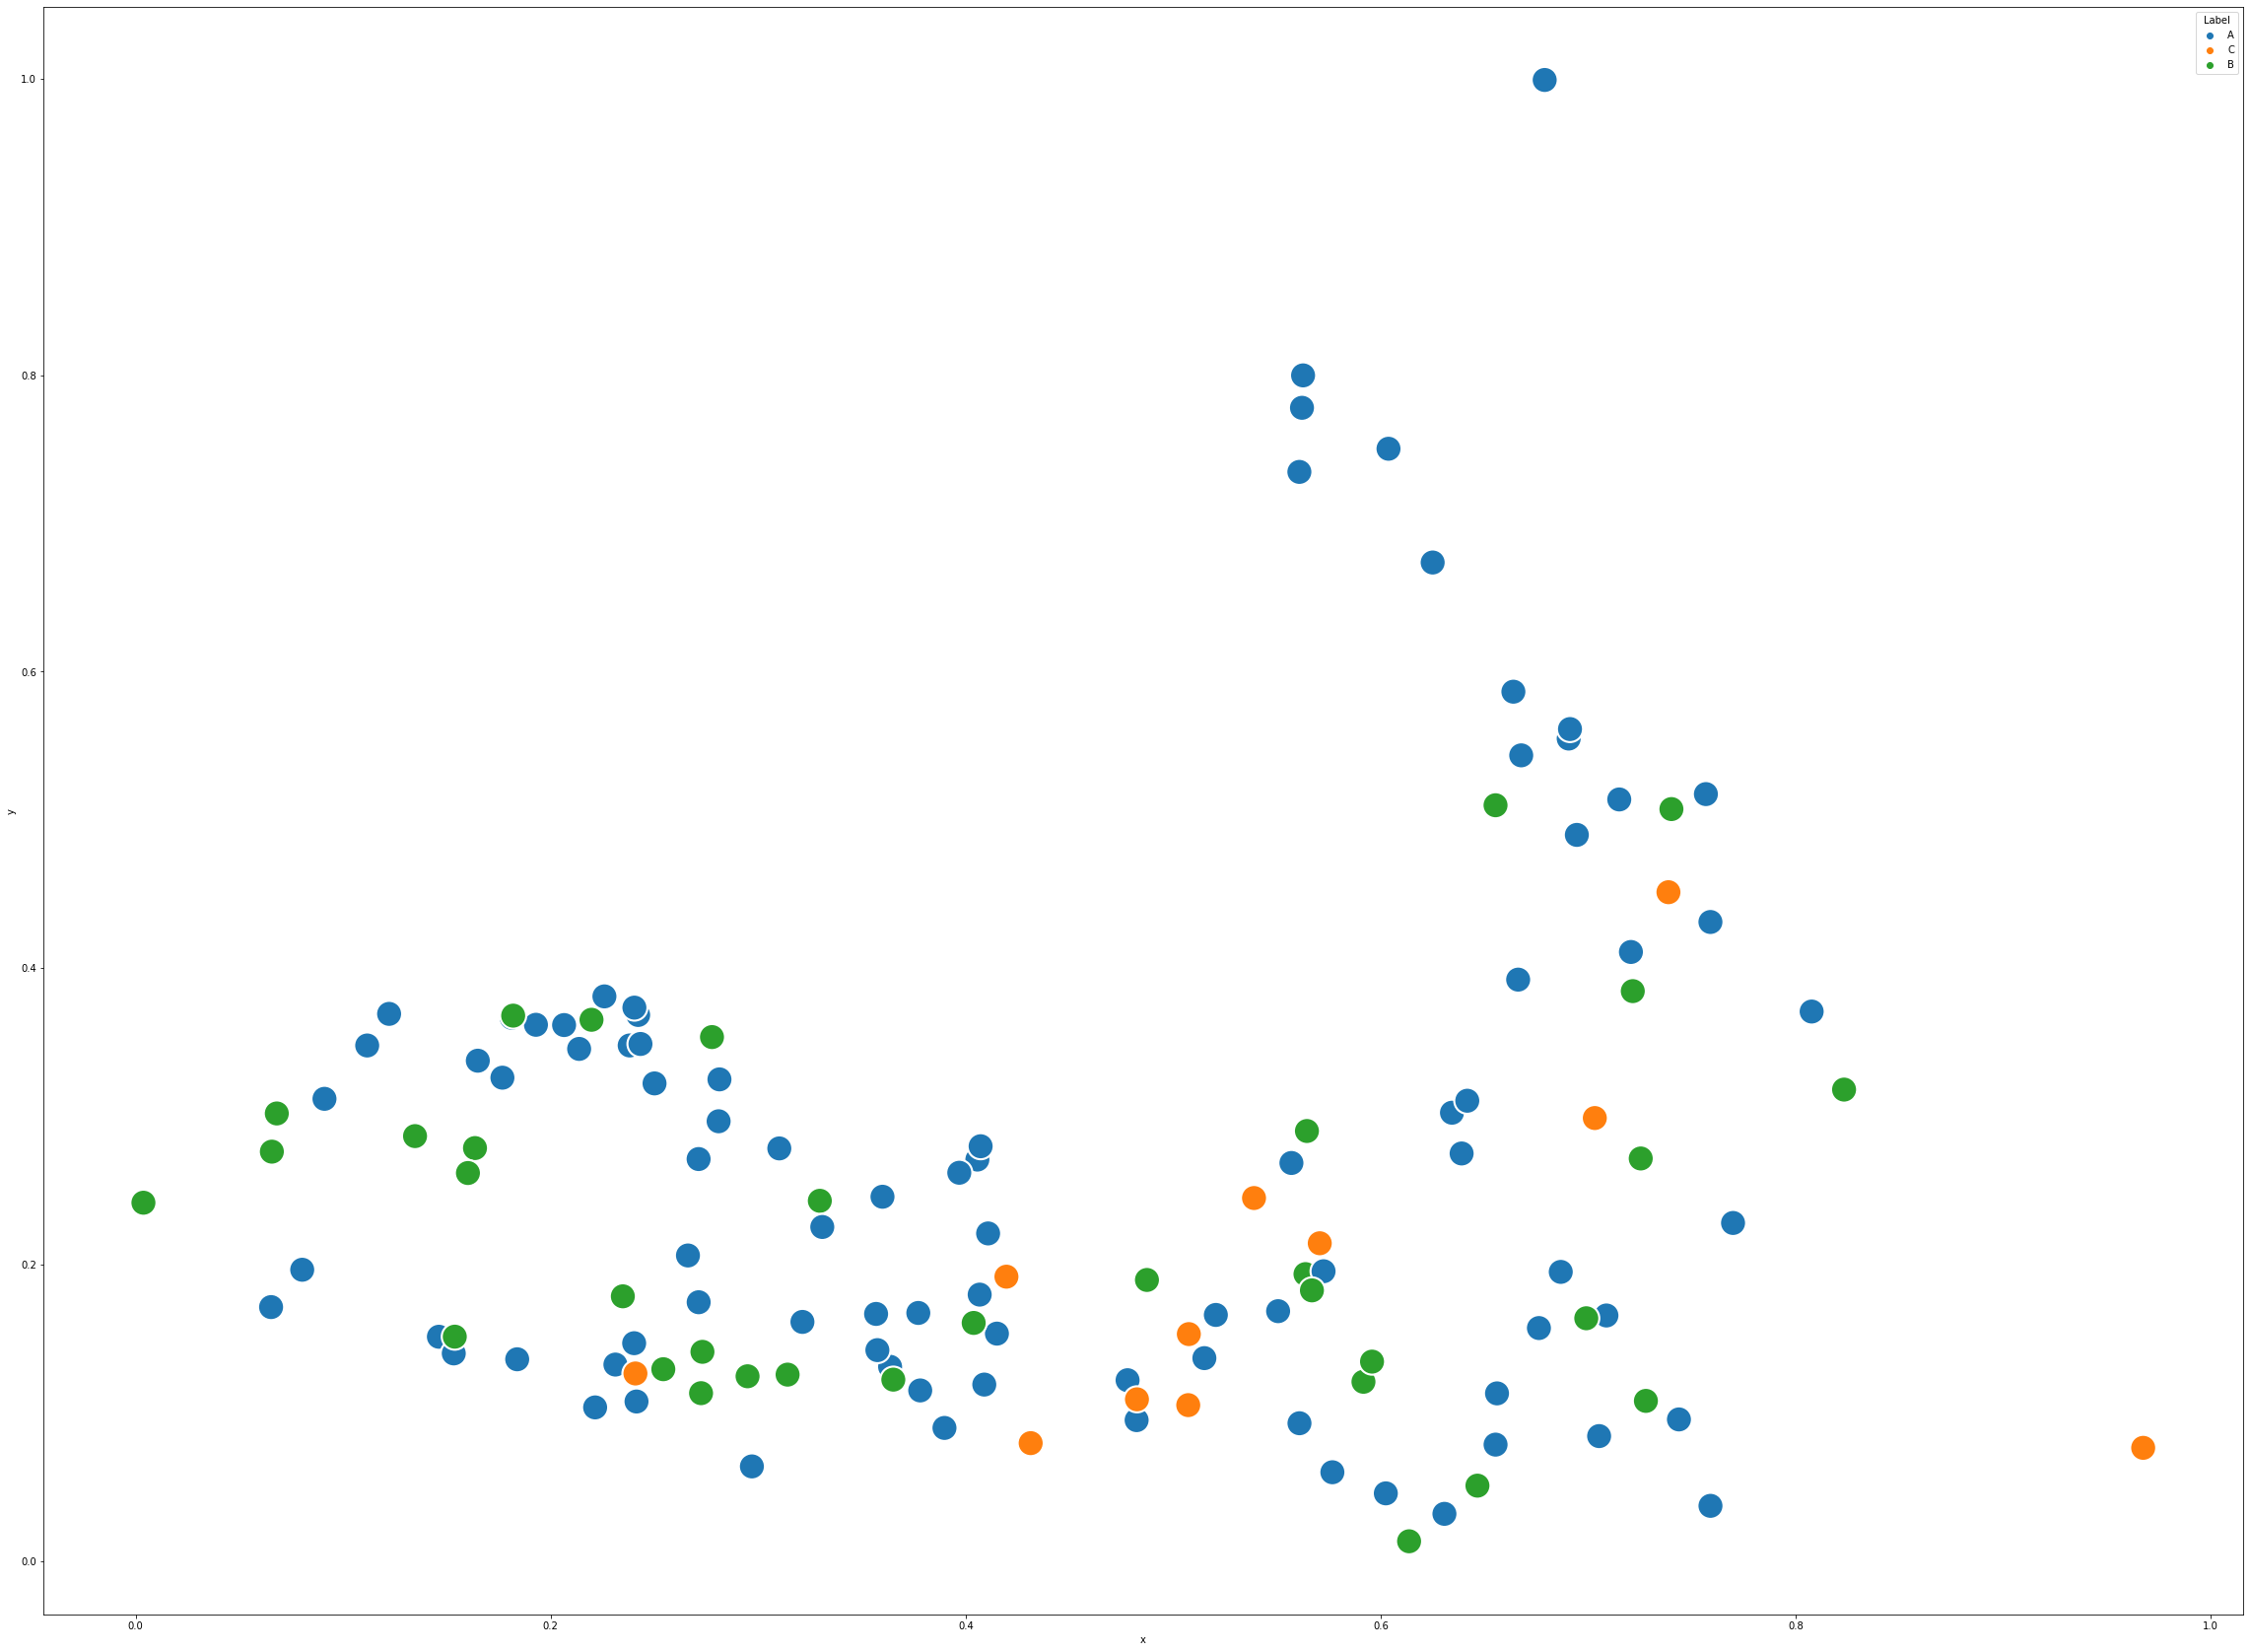

In [310]:
fig = plt.figure()

ax = sns.scatterplot(x="x",y="y",data=df,hue= "Label",s=700)

fig.set_size_inches(40,30)


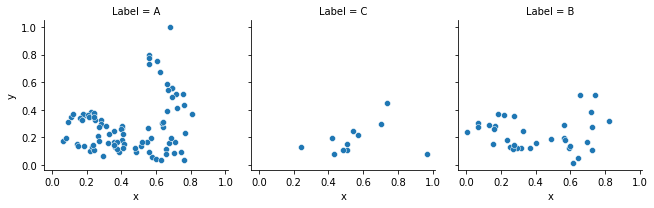

In [311]:
grid = sns.FacetGrid(data=df, col = "Label",col_wrap=4)
grid.map(sns.scatterplot, "x", "y")

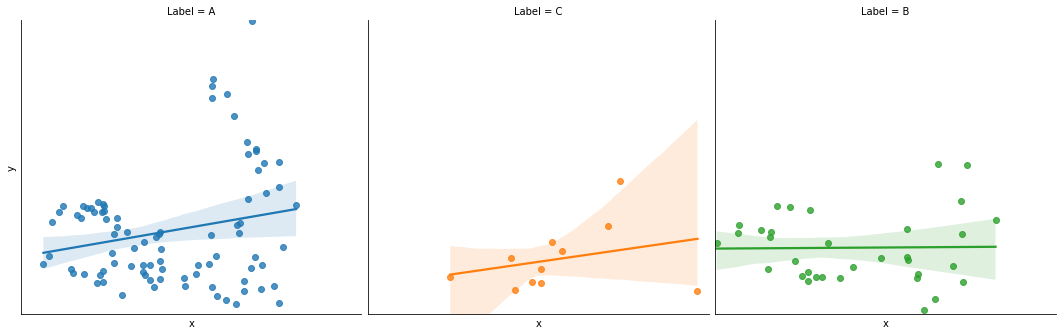

In [312]:
g = sns.lmplot(x="x", y="y", col="Label", hue="Label",
               data=df, col_wrap=4)
g = (g.set_axis_labels()
      .set(xlim=(0, 1), ylim=(0, 1),
           xticks=[10, 30, 50], yticks=[2, 6, 10])
      .fig.subplots_adjust(wspace=.02))

In [296]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')